In [18]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as pl
import shap

In [ ]:
# Initialize VADER sentiment analyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()


In [3]:

# Define the ticker symbol
ticker = 'AAPL'

# Define the date range
start_date = '2014-01-01'
end_date = '2024-10-01'

# Download historical data
data = yf.download(ticker, start=start_date, end=end_date, progress=False)

# Display the first few rows
print(data.head())


                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2014-01-02  19.845715  19.893929  19.715000  19.754642  17.253262  234684800
2014-01-03  19.745001  19.775000  19.301071  19.320715  16.874279  392467600
2014-01-06  19.194643  19.528570  19.057142  19.426071  16.966291  412610800
2014-01-07  19.440001  19.498571  19.211430  19.287144  16.844957  317209200
2014-01-08  19.243214  19.484285  19.238930  19.409286  16.951632  258529600


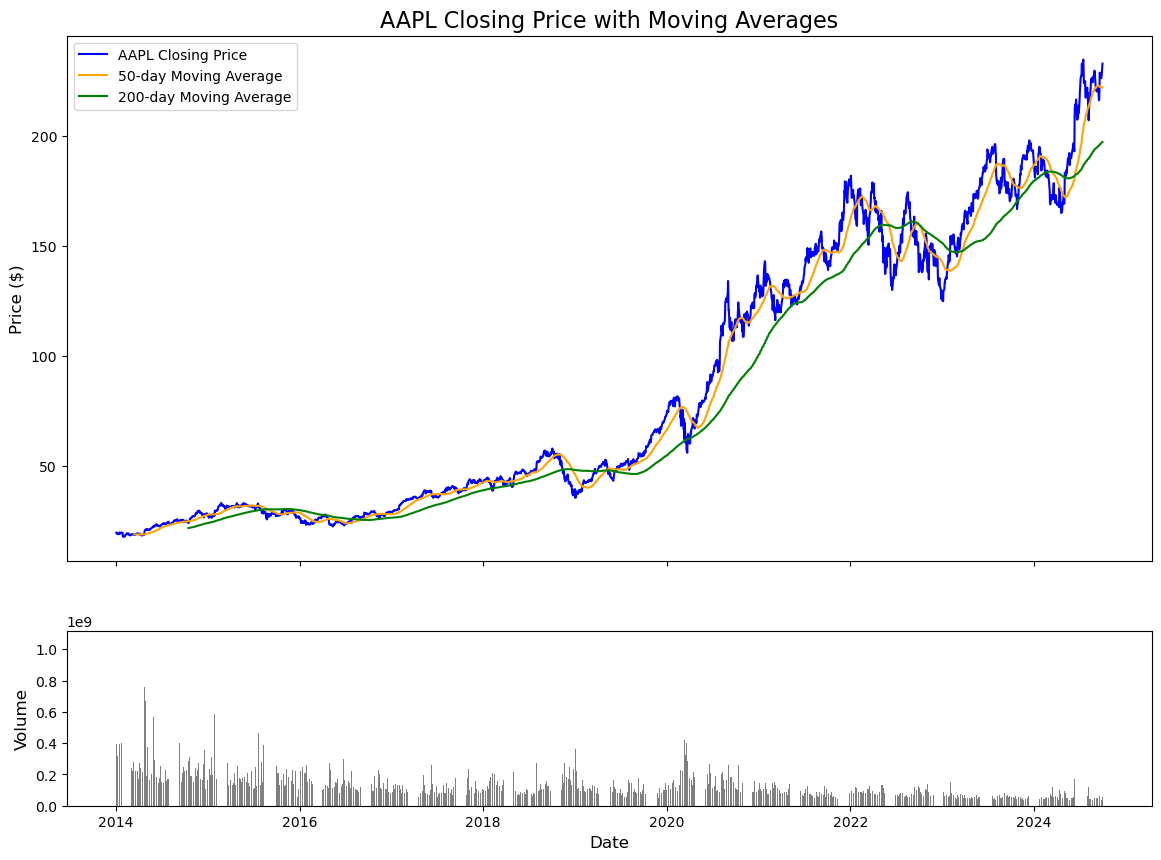

In [5]:
# Calculate moving averages for better visualization
data['MA50'] = data['Close'].rolling(window=50).mean()  # 50-day moving average
data['MA200'] = data['Close'].rolling(window=200).mean()  # 200-day moving average

# Create subplots: one for the price and moving averages, one for the volume
fig, ax = plt.subplots(2, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot the closing price with moving averages
ax[0].plot(data.index, data['Close'], label='AAPL Closing Price', color='blue')
ax[0].plot(data.index, data['MA50'], label='50-day Moving Average', color='orange')
ax[0].plot(data.index, data['MA200'], label='200-day Moving Average', color='green')
ax[0].set_title('AAPL Closing Price with Moving Averages', fontsize=16)
ax[0].set_ylabel('Price ($)', fontsize=12)
ax[0].legend()

# Plot the volume in the second subplot
ax[1].bar(data.index, data['Volume'], color='gray', label='Volume')
ax[1].set_ylabel('Volume', fontsize=12)
ax[1].set_xlabel('Date', fontsize=12)

# Show the plot
plt.show()


In [7]:
# Fetch real-time stock data for AAPL (1-minute interval for the current day)
aapl = yf.Ticker("AAPL")
data = aapl.history(period="1d", interval="1m")  # Get 1-minute intervals for today

# Calculate technical indicators (SMA, EMA, RSI)
data['SMA_20'] = data['Close'].rolling(window=20).mean()  # Simple Moving Average (20 periods)
data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()  # Exponential Moving Average
data['Price_Change'] = data['Close'].diff()  # Price change

In [8]:
# RSI Calculation
def calculate_RSI(series, period=14):
    delta = series.diff(1)
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [9]:

data['RSI_14'] = calculate_RSI(data['Close'])  # 14-period RSI

In [10]:
# Fill missing values after rolling calculations
data.fillna(method='bfill', inplace=True)

# Display processed data
print(data.tail())

                                 Open        High         Low       Close  \
Datetime                                                                    
2024-09-30 15:55:00-04:00  232.199997  232.750000  232.190002  232.580002   
2024-09-30 15:56:00-04:00  232.589996  232.750000  232.330002  232.440002   
2024-09-30 15:57:00-04:00  232.449997  232.979996  232.449997  232.958801   
2024-09-30 15:58:00-04:00  232.960007  233.000000  232.800003  232.940002   
2024-09-30 15:59:00-04:00  232.949997  233.000000  232.509995  233.000000   

                            Volume  Dividends  Stock Splits      SMA_20  \
Datetime                                                                  
2024-09-30 15:55:00-04:00   899046        0.0           0.0  231.543806   
2024-09-30 15:56:00-04:00   627348        0.0           0.0  231.609236   
2024-09-30 15:57:00-04:00   663297        0.0           0.0  231.699176   
2024-09-30 15:58:00-04:00   593016        0.0           0.0  231.781676   
2024-09-30

C:\Users\flyin\AppData\Local\Temp\ipykernel_117516\2751679554.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [14]:
# Define features and target
features = ['SMA_20', 'EMA_20', 'RSI_14', 'Price_Change']
target = np.where(data['Price_Change'].shift(-1) > 0, 1, 0)  # 1 if price increases, 0 if decreases


In [15]:
X = data[features].values
y = target

In [16]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Train a LightGBM model
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [20]:
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'boosting_type': 'gbdt',
    'verbose': -1
}

In [27]:
# Define validation dataset properly
valid_data = lgb.Dataset(X_test, label=y_test)

# Train the model with early stopping
model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=[valid_data],  # Only use valid_data for early stopping
    early_stopping_rounds=50,  # Stop if no improvement after 50 rounds
    verbose_eval=True  # Show progress
)


TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]

In [ ]:
# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

In [ ]:
print(f"Model accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print("Confusion Matrix:\n", conf_matrix)

In [ ]:
# Function to compute feature importance
def get_feature_importance(model, importance_type='split'):
    fi = pd.Series(model.feature_importance(importance_type=importance_type), 
                   index=model.feature_name())
    return fi / fi.sum()

In [ ]:
# Feature importance by 'split' and 'gain'
feature_importance = (get_feature_importance(model).to_frame('Split').
                      join(get_feature_importance(model, 'gain').to_frame('Gain')))


In [ ]:
# Plot top 20 features by gain
(feature_importance
 .nlargest(20, columns='Gain')
 .sort_values('Gain', ascending=False)
 .plot
 .bar(subplots=True, layout=(2, 1), figsize=(14, 6), legend=False, sharey=True, rot=0))

plt.suptitle('Normalized Importance (Top 20 Features)', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.9)
plt.show()

In [ ]:
import shap

# SHAP analysis for model interpretability
X_sample = X_test  # Sample of test data for SHAP analysis
shap.initjs()  # Load JS for SHAP plots

# SHAP explanation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# SHAP summary plot (scatter and bar)
shap.summary_plot(shap_values, X_sample, show=False)
plt.tight_layout()

shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.tight_layout()


In [62]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol
ticker_symbol = 'AAPL'

# Set the date range for 10 years
start_date = '2013-01-01'
end_date = '2023-10-01'  # Adjust to current date if needed

# Fetch the ticker object
aapl_ticker = yf.Ticker(ticker_symbol)

# Download historical market data
aapl_market_data = aapl_ticker.history(start=start_date, end=end_date)

# Display the first few rows
print(aapl_market_data.head())

# Save to CSV
aapl_market_data.to_csv('data/aapl_market_data_10y.csv')


                                Open       High        Low      Close  \
Date                                                                    
2013-01-02 00:00:00-05:00  16.851449  16.887354  16.480537  16.705700   
2013-01-03 00:00:00-05:00  16.670707  16.725172  16.461365  16.494835   
2013-01-04 00:00:00-05:00  16.338749  16.389259  15.999784  16.035385   
2013-01-07 00:00:00-05:00  15.883245  16.105366  15.676337  15.941058   
2013-01-08 00:00:00-05:00  16.102624  16.184170  15.860420  15.983955   

                              Volume  Dividends  Stock Splits  
Date                                                           
2013-01-02 00:00:00-05:00  560518000        0.0           0.0  
2013-01-03 00:00:00-05:00  352965200        0.0           0.0  
2013-01-04 00:00:00-05:00  594333600        0.0           0.0  
2013-01-07 00:00:00-05:00  484156400        0.0           0.0  
2013-01-08 00:00:00-05:00  458707200        0.0           0.0  


In [63]:
import pandas as pd

# Fetch financial statements
income_statement = aapl_ticker.financials
balance_sheet = aapl_ticker.balance_sheet
cash_flow = aapl_ticker.cashflow

# Convert columns to datetime
income_statement.columns = pd.to_datetime(income_statement.columns)
balance_sheet.columns = pd.to_datetime(balance_sheet.columns)
cash_flow.columns = pd.to_datetime(cash_flow.columns)

# Filter data for the last 10 years
income_statement_10y = income_statement.loc[:, income_statement.columns >= start_date]
balance_sheet_10y = balance_sheet.loc[:, balance_sheet.columns >= start_date]
cash_flow_10y = cash_flow.loc[:, cash_flow.columns >= start_date]

# Display the data
print("Income Statement (Last 10 Years):")
print(income_statement_10y)

print("\nBalance Sheet (Last 10 Years):")
print(balance_sheet_10y)

print("\nCash Flow Statement (Last 10 Years):")
print(cash_flow_10y)

# Save to CSV
income_statement_10y.to_csv('data/aapl_income_statement_10y.csv')
balance_sheet_10y.to_csv('data/aapl_balance_sheet_10y.csv')
cash_flow_10y.to_csv('data/aapl_cash_flow_10y.csv')


Income Statement (Last 10 Years):
                                                        2023-09-30  \
Tax Effect Of Unusual Items                                    0.0   
Tax Rate For Calcs                                           0.147   
Normalized EBITDA                                   129188000000.0   
Net Income From Continuing Operation Net Minori...   96995000000.0   
Reconciled Depreciation                              11519000000.0   
Reconciled Cost Of Revenue                          214137000000.0   
EBITDA                                              129188000000.0   
EBIT                                                117669000000.0   
Net Interest Income                                   -183000000.0   
Interest Expense                                      3933000000.0   
Interest Income                                       3750000000.0   
Normalized Income                                    96995000000.0   
Net Income From Continuing And Discontinued Ope...   969

In [64]:
import requests
import pandas as pd

api_key = 'l4kqVvNcvaHnvqV6b8xDQzFIemo75TuP'  # Replace with your actual API key
ticker_symbol = 'AAPL'

# Fetch Income Statement (limit=10 for 10 years)
income_statement_url = f'https://financialmodelingprep.com/api/v3/income-statement/{ticker_symbol}?limit=10&apikey={api_key}'
income_statement = requests.get(income_statement_url).json()
income_statement_df = pd.DataFrame(income_statement)

# Fetch Balance Sheet
balance_sheet_url = f'https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker_symbol}?limit=10&apikey={api_key}'
balance_sheet = requests.get(balance_sheet_url).json()
balance_sheet_df = pd.DataFrame(balance_sheet)

# Fetch Cash Flow Statement
cash_flow_url = f'https://financialmodelingprep.com/api/v3/cash-flow-statement/{ticker_symbol}?limit=10&apikey={api_key}'
cash_flow = requests.get(cash_flow_url).json()
cash_flow_df = pd.DataFrame(cash_flow)

# Display the data
print("Income Statement (Last 10 Years):")
print(income_statement_df[['date', 'revenue', 'netIncome']])

print("\nBalance Sheet (Last 10 Years):")
print(balance_sheet_df[['date', 'totalAssets', 'totalLiabilities']])

print("\nCash Flow Statement (Last 10 Years):")
print(cash_flow_df[['date', 'netCashProvidedByOperatingActivities', 'capitalExpenditure']])

# Save to CSV
income_statement_df.to_csv('data/fmp_aapl_income_statement_10y.csv', index=False)
balance_sheet_df.to_csv('data/fmp_aapl_balance_sheet_10y.csv', index=False)
cash_flow_df.to_csv('data/fmp_aapl_cash_flow_10y.csv', index=False)


Income Statement (Last 10 Years):
         date       revenue    netIncome
0  2023-09-30  383285000000  96995000000
1  2022-09-24  394328000000  99803000000
2  2021-09-25  365817000000  94680000000
3  2020-09-26  274515000000  57411000000
4  2019-09-28  260174000000  55256000000

Balance Sheet (Last 10 Years):
         date   totalAssets  totalLiabilities
0  2023-09-30  352583000000      290437000000
1  2022-09-24  352755000000      302083000000
2  2021-09-25  351002000000      287912000000
3  2020-09-26  323888000000      258549000000
4  2019-09-28  338516000000      248028000000

Cash Flow Statement (Last 10 Years):
         date  netCashProvidedByOperatingActivities  capitalExpenditure
0  2023-09-30                          110543000000        -10959000000
1  2022-09-24                          122151000000        -10708000000
2  2021-09-25                          104038000000        -11085000000
3  2020-09-26                           80674000000         -7309000000
4  2019-09-28 

In [65]:
import requests
import pandas as pd

api_key = '89FD9C184SJT3BR3'  # Replace with your actual API key
ticker_symbol = 'AAPL'

# Fetch Income Statement
income_statement_url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={ticker_symbol}&apikey={api_key}'
income_statement_response = requests.get(income_statement_url)
income_statement_data = income_statement_response.json()
income_statement_df = pd.DataFrame(income_statement_data['annualReports'])

# Fetch Balance Sheet
balance_sheet_url = f'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={ticker_symbol}&apikey={api_key}'
balance_sheet_response = requests.get(balance_sheet_url)
balance_sheet_data = balance_sheet_response.json()
balance_sheet_df = pd.DataFrame(balance_sheet_data['annualReports'])

# Fetch Cash Flow Statement
cash_flow_url = f'https://www.alphavantage.co/query?function=CASH_FLOW&symbol={ticker_symbol}&apikey={api_key}'
cash_flow_response = requests.get(cash_flow_url)
cash_flow_data = cash_flow_response.json()
cash_flow_df = pd.DataFrame(cash_flow_data['annualReports'])

# Filter data for the last 10 years
start_year = 2013
income_statement_df = income_statement_df[income_statement_df['fiscalDateEnding'] >= f'{start_year}-01-01']
balance_sheet_df = balance_sheet_df[balance_sheet_df['fiscalDateEnding'] >= f'{start_year}-01-01']
cash_flow_df = cash_flow_df[cash_flow_df['fiscalDateEnding'] >= f'{start_year}-01-01']

# Display the data
print("Income Statement (Last 10 Years):")
print(income_statement_df[['fiscalDateEnding', 'totalRevenue', 'netIncome']])

print("\nBalance Sheet (Last 10 Years):")
print(balance_sheet_df[['fiscalDateEnding', 'totalAssets', 'totalLiabilities']])

print("\nCash Flow Statement (Last 10 Years):")
print(cash_flow_df[['fiscalDateEnding', 'operatingCashflow', 'capitalExpenditures']])

# Save to CSV
income_statement_df.to_csv('data/av_aapl_income_statement_10y.csv', index=False)
balance_sheet_df.to_csv('data/av_aapl_balance_sheet_10y.csv', index=False)
cash_flow_df.to_csv('data/av_aapl_cash_flow_10y.csv', index=False)


Income Statement (Last 10 Years):
   fiscalDateEnding  totalRevenue    netIncome
0        2023-09-30  379352000000  96995000000
1        2022-09-30  391397000000  99803000000
2        2021-09-30  363172000000  94680000000
3        2020-09-30  271642000000  57411000000
4        2019-09-30  256598000000  55256000000
5        2018-09-30  265595000000  59531000000
6        2017-09-30  229234000000  48351000000
7        2016-09-30  215639000000  45687000000
8        2015-09-30  232982000000  53394000000
9        2014-09-30  182411000000  39510000000
10       2013-09-30  170774000000  37037000000

Balance Sheet (Last 10 Years):
   fiscalDateEnding   totalAssets totalLiabilities
0        2023-09-30  352583000000     290437000000
1        2022-09-30  352755000000     302083000000
2        2021-09-30  351002000000     287912000000
3        2020-09-30  323888000000     258549000000
4        2019-09-30  338516000000     248028000000
5        2018-09-30  365725000000     258578000000
6        2017

In [ ]:
import pandas as pd

# Load market data
aapl_market_data = pd.read_csv('data/aapl_market_data_10y.csv', index_col='Date', parse_dates=True)

# Load fundamental data (from FinancialModelingPrep as an example)
income_statement_df = pd.read_csv('data/fmp_aapl_income_statement_10y.csv', parse_dates=['date'])
balance_sheet_df = pd.read_csv('data/fmp_aapl_balance_sheet_10y.csv', parse_dates=['date'])

# Select relevant columns and rename for clarity
fundamental_data = income_statement_df[['date', 'revenue', 'netIncome']]
fundamental_data = fundamental_data.rename(columns={'date': 'ReportDate'})

# Since financial statements are reported periodically, we need to align them with daily market data.
# We'll forward-fill the fundamental data for each day until the next report.

# Set 'ReportDate' as index
fundamental_data.set_index('ReportDate', inplace=True)

# Resample to daily frequency and forward-fill
fundamental_daily = fundamental_data.resample('D').ffill()

# Reindex to match market data dates
fundamental_daily = fundamental_daily.reindex(aapl_market_data.index, method='ffill')

# Combine market data and fundamental data
aapl_combined_data = aapl_market_data.join(fundamental_daily)

# Display the combined data
print(aapl_combined_data.head())

# Save to CSV
aapl_combined_data.to_csv('data/aapl_combined_data_10y.csv')


In [56]:
"""import requests

api_key = 'f5bdcf3fbfaa4036a032fa8182915817'
query = 'Apple Inc'
from_date = '2023-01-01'  # Adjust the date range as needed
to_date = '2023-10-01'

news_url = ('https://newsapi.org/v2/everything?'
            f'q={query}&from={from_date}&to={to_date}&sortBy=popularity&language=en&apiKey={api_key}')

response = requests.get(news_url)
news_data = response.json()

# Check the number of articles retrieved
print(f"Total articles retrieved: {news_data['totalResults']}")
"""

'import requests\n\napi_key = \'f5bdcf3fbfaa4036a032fa8182915817\'\nquery = \'Apple Inc\'\nfrom_date = \'2023-01-01\'  # Adjust the date range as needed\nto_date = \'2023-10-01\'\n\nnews_url = (\'https://newsapi.org/v2/everything?\'\n            f\'q={query}&from={from_date}&to={to_date}&sortBy=popularity&language=en&apiKey={api_key}\')\n\nresponse = requests.get(news_url)\nnews_data = response.json()\n\n# Check the number of articles retrieved\nprint(f"Total articles retrieved: {news_data[\'totalResults\']}")\n'

In [ ]:
89FD9C184SJT3BR3

In [39]:
import requests

api_key = '89FD9C184SJT3BR3'
ticker_symbol = 'AAPL'

# Fetch News and Sentiment Data
url = (f'https://www.alphavantage.co/query?'
       f'function=NEWS_SENTIMENT&tickers={ticker_symbol}&apikey={api_key}')

response = requests.get(url)
data = response.json()

# Parse the news articles
articles = data.get('feed', [])

# Create DataFrame
news_df = pd.DataFrame(articles)

# Display the first few articles
print(news_df[['time_published', 'title', 'overall_sentiment_score']].head())


    time_published                                              title  \
0  20240923T132101  Taiwan Semiconductor Denies UAE Investment Rum...   
1  20240923T115956  Tesla Stock Outperforms Magnificent 7 Peers In...   
2  20240923T104000  These "Magnificent Seven" Stocks Are Brilliant...   
3  20240923T102008  Should You Invest in the Technology Select Sec...   
4  20240923T102008  Should Motley Fool 100 Index ETF  ( TMFC )  Be...   

   overall_sentiment_score  
0                 0.265683  
1                 0.101022  
2                 0.267242  
3                 0.193582  
4                 0.118326  


In [40]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL for Apple's Yahoo Finance news page
news_url = 'https://finance.yahoo.com/quote/AAPL/news?p=AAPL'

# Make a request to the page
response = requests.get(news_url)
soup = BeautifulSoup(response.content, 'html.parser')

# Find all news articles
articles = soup.find_all('h3', class_='Mb(5px)')

news_data = []

for article in articles:
    headline = article.get_text()
    link = 'https://finance.yahoo.com' + article.find('a')['href']
    news_data.append({'headline': headline, 'link': link})

# Convert to DataFrame
news_df = pd.DataFrame(news_data)
print(news_df.head())


Empty DataFrame
Columns: []
Index: []


In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def parse_timestamp(timestamp_str):
    # Get the current date and time
    now = datetime.now()

    if 'Today' in timestamp_str:
        time_part = timestamp_str.replace('Today ', '')
        date_part = now.strftime('%Y-%m-%d')
        timestamp = f"{date_part} {time_part}"
    elif 'Yesterday' in timestamp_str:
        time_part = timestamp_str.replace('Yesterday ', '')
        date_part = (now - timedelta(days=1)).strftime('%Y-%m-%d')
        timestamp = f"{date_part} {time_part}"
    else:
        # Assume format is like 'Oct-05-23 09:00AM'
        timestamp = timestamp_str

    return timestamp


def get_finviz_news(ticker):
    url = f'https://finviz.com/quote.ashx?t={ticker}'
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    news_table = soup.find(id='news-table')
    news_rows = news_table.findAll('tr')

    parsed_news = []

    for row in news_rows:
        columns = row.findAll('td')
        if len(columns) == 2:
            raw_timestamp = columns[0].text.strip()
            headline = columns[1].text.strip()
            timestamp = parse_timestamp(raw_timestamp)
            parsed_news.append({'timestamp': timestamp, 'headline': headline})

    return pd.DataFrame(parsed_news)

# Get news for AAPL
news_df = get_finviz_news('AAPL')

# Convert timestamps to datetime objects
news_df['timestamp'] = pd.to_datetime(news_df['timestamp'], format='%Y-%m-%d %I:%M%p', errors='coerce')

# Handle any remaining NaT values
news_df.dropna(subset=['timestamp'], inplace=True)

# Perform sentiment analysis
news_df['sentiment'] = news_df['headline'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Display the first few rows
print(news_df.head())


            timestamp                                           headline  \
0 2024-10-01 18:41:00  Apple Stock Is Back Near Record High. New Phon...   

   sentiment  
0     -0.128  


In [5]:
import quandl

# Set your API key
quandl.ApiConfig.api_key = 'uDwSxZx8oTEeFSc-3yZG'

# Fetch Apple's fundamentals (e.g., quarterly income statements)
# Note: As of my knowledge cutoff in September 2021, Quandl's financial data may be limited.
# Ensure you have access to the required datasets or consider alternative providers.

# Example placeholder code
# fundamentals = quandl.get_table('SHARADAR/SF1', ticker='AAPL', qopts={'columns': ['dimension', 'datekey', 'revenue', 'netinc']}, paginate=True)

# Since access may be restricted, consider alternative sources.


FinancialModelingPrep offers free access to extensive financial data via their API.

Sign Up and Obtain API Key
Visit FinancialModelingPrep and sign up for a free API key.

In [47]:
import requests
import pandas as pd

api_key = 'l4kqVvNcvaHnvqV6b8xDQzFIemo75TuP'  # Replace with your API key
ticker_symbol = 'AAPL'

# Fetch Income Statement
income_statement_url = f'https://financialmodelingprep.com/api/v3/income-statement/{ticker_symbol}?limit=120&apikey={api_key}'
income_statement = requests.get(income_statement_url).json()
income_statement_df = pd.DataFrame(income_statement)
print("Income Statement:")
print(income_statement_df.head())

# Fetch Balance Sheet
balance_sheet_url = f'https://financialmodelingprep.com/api/v3/balance-sheet-statement/{ticker_symbol}?limit=120&apikey={api_key}'
balance_sheet = requests.get(balance_sheet_url).json()
balance_sheet_df = pd.DataFrame(balance_sheet)
print("\nBalance Sheet:")
print(balance_sheet_df.head())

# Fetch Cash Flow Statement
cash_flow_url = f'https://financialmodelingprep.com/api/v3/cash-flow-statement/{ticker_symbol}?limit=120&apikey={api_key}'
cash_flow = requests.get(cash_flow_url).json()
cash_flow_df = pd.DataFrame(cash_flow)
print("\nCash Flow Statement:")
print(cash_flow_df.head())

# Fetch Financial Ratios
ratios_url = f'https://financialmodelingprep.com/api/v3/ratios/{ticker_symbol}?limit=40&apikey={api_key}'
ratios = requests.get(ratios_url).json()
ratios_df = pd.DataFrame(ratios)
print("\nFinancial Ratios:")
print(ratios_df.head())


Income Statement:
         date symbol reportedCurrency         cik fillingDate  \
0  2023-09-30   AAPL              USD  0000320193  2023-11-03   
1  2022-09-24   AAPL              USD  0000320193  2022-10-28   
2  2021-09-25   AAPL              USD  0000320193  2021-10-29   
3  2020-09-26   AAPL              USD  0000320193  2020-10-30   
4  2019-09-28   AAPL              USD  0000320193  2019-10-31   

          acceptedDate calendarYear period       revenue  costOfRevenue  ...  \
0  2023-11-02 18:08:27         2023     FY  383285000000   214137000000  ...   
1  2022-10-27 18:01:14         2022     FY  394328000000   223546000000  ...   
2  2021-10-28 18:04:28         2021     FY  365817000000   212981000000  ...   
3  2020-10-29 18:06:25         2020     FY  274515000000   169559000000  ...   
4  2019-10-30 18:12:36         2019     FY  260174000000   161782000000  ...   

   incomeBeforeTaxRatio  incomeTaxExpense    netIncome  netIncomeRatio   eps  \
0              0.296740       

In [7]:
import requests
#ALpha vantage
# Define the API key and base URL
api_key = 'l4kqVvNcvaHnvqV6b8xDQzFIemo75TuP'
base_url = 'https://financialmodelingprep.com/api/v3'

# Fetch income statement
income_statement_url = f'{base_url}/income-statement/{ticker}?apikey={api_key}&limit=120'
income_statement = requests.get(income_statement_url).json()
income_df = pd.DataFrame(income_statement)

# Fetch balance sheet
balance_sheet_url = f'{base_url}/balance-sheet-statement/{ticker}?apikey={api_key}&limit=120'
balance_sheet = requests.get(balance_sheet_url).json()
balance_sheet_df = pd.DataFrame(balance_sheet)

# Fetch cash flow statement
cash_flow_url = f'{base_url}/cash-flow-statement/{ticker}?apikey={api_key}&limit=120'
cash_flow = requests.get(cash_flow_url).json()
cash_flow_df = pd.DataFrame(cash_flow)

# Fetch key metrics
key_metrics_url = f'{base_url}/key-metrics/{ticker}?apikey={api_key}&limit=120'
key_metrics = requests.get(key_metrics_url).json()
key_metrics_df = pd.DataFrame(key_metrics)

# Display the first few rows of key metrics
print(key_metrics_df.head())


  symbol        date calendarYear period  revenuePerShare  netIncomePerShare  \
0   AAPL  2023-09-30         2023     FY        24.344473           6.160669   
1   AAPL  2022-09-24         2022     FY        24.317273           6.154614   
2   AAPL  2021-09-25         2021     FY        21.903541           5.669029   
3   AAPL  2020-09-26         2020     FY        15.820258           3.308587   
4   AAPL  2019-09-28         2019     FY        14.085283           2.991446   

   operatingCashFlowPerShare  freeCashFlowPerShare  cashPerShare  \
0                   7.021175              6.325110      3.909686   
1                   7.532763              6.872426      2.978793   
2                   6.229346              5.565624      3.750553   
3                   4.649230              4.228014      5.241031   
4                   3.756685              3.188508      5.443948   

   bookValuePerShare  ...  averagePayables  averageInventory  \
0           3.947224  ...      63363000000    

In [54]:
"""import tweepy

# Authenticate to Twitter
consumer_key = 'aJa5M2W25h4XXqC5AERjF8nPk'
consumer_secret = 'ZD3axZPJ2yLeaVK9tVGmEfIc8rdsfLS5VlgXWFvKeabqOedyXT'
access_token = '1838204353225850880-HxHo43P1N5i1APkKOIhrVdlQFRtIew'
access_token_secret = 'Ot4aiIo9g7i9ne1woHnN4HMWOKjb9ymBaRZV7paNXk5jC'

auth = tweepy.OAuth1UserHandler(consumer_key, consumer_secret, access_token, access_token_secret)
api = tweepy.API(auth)

# Search for tweets mentioning Apple
tweets = tweepy.Cursor(api.search_tweets, q='Apple OR $AAPL', lang='en', since='2023-01-01').items(1000)

# Store tweets in a list
tweet_texts = [tweet.text for tweet in tweets]

# Display a sample tweet
print(tweet_texts[0])
#AAAAAAAAAAAAAAAAAAAAAOIiwAEAAAAAgICZKvSY%2Fi9DAsmgiCWO6RJMSg0%3DzPtpzP0tSuvnyYOBewA4J4bEUnlJSxbDcuftAaqEmkjnAAyY0I
"""

"import tweepy\n\n# Authenticate to Twitter\nconsumer_key = 'aJa5M2W25h4XXqC5AERjF8nPk'\nconsumer_secret = 'ZD3axZPJ2yLeaVK9tVGmEfIc8rdsfLS5VlgXWFvKeabqOedyXT'\naccess_token = '1838204353225850880-HxHo43P1N5i1APkKOIhrVdlQFRtIew'\naccess_token_secret = 'Ot4aiIo9g7i9ne1woHnN4HMWOKjb9ymBaRZV7paNXk5jC'\n\nauth = tweepy.OAuth1UserHandler(consumer_key, consumer_secret, access_token, access_token_secret)\napi = tweepy.API(auth)\n\n# Search for tweets mentioning Apple\ntweets = tweepy.Cursor(api.search_tweets, q='Apple OR $AAPL', lang='en', since='2023-01-01').items(1000)\n\n# Store tweets in a list\ntweet_texts = [tweet.text for tweet in tweets]\n\n# Display a sample tweet\nprint(tweet_texts[0])\n#AAAAAAAAAAAAAAAAAAAAAOIiwAEAAAAAgICZKvSY%2Fi9DAsmgiCWO6RJMSg0%3DzPtpzP0tSuvnyYOBewA4J4bEUnlJSxbDcuftAaqEmkjnAAyY0I\n"

In [21]:
"""
import tweepy

# Correct Bearer Token for OAuth 2.0 App Only
bearer_token = 'YOUR_NEWLY_GENERATED_BEARER_TOKEN'

# Initialize tweepy Client
client = tweepy.Client(bearer_token=bearer_token)

# Define search query and parameters
query = 'Apple OR $AAPL'
start_time = '2024-01-01T00:00:00Z'  # ISO format for date-time

# Search for recent tweets mentioning Apple
response = client.search_recent_tweets(query=query, start_time=start_time, max_results=10)

# Check if there are tweets in the response
if response.data:
    tweet_texts = [tweet.text for tweet in response.data]
    print(tweet_texts[0])
else:
    print("No tweets found.")

# Access rate limit information from the response headers
rate_limit = response.headers.get('x-rate-limit-limit')
remaining_requests = response.headers.get('x-rate-limit-remaining')
reset_time = response.headers.get('x-rate-limit-reset')

print(f"Rate limit: {rate_limit}")
print(f"Remaining requests: {remaining_requests}")
print(f"Rate limit resets at: {reset_time}")
"""

Unauthorized: 401 Unauthorized
Unauthorized

In [53]:

"""import tweepy
from datetime import datetime

# Authenticate to Twitter with API v2
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAOIiwAEAAAAAgICZKvSY%2Fi9DAsmgiCWO6RJMSg0%3DzPtpzP0tSuvnyYOBewA4J4bEUnlJSxbDcuftAaqEmkjnAAyY0I'

client = tweepy.Client(bearer_token=bearer_token)

# Define search query and parameters
query = 'Apple OR $AAPL'
start_time = '2024-01-01T00:00:00Z'  # API v2 uses ISO format for date-time

# Search for tweets mentioning Apple
tweets = client.search_recent_tweets(query=query, start_time=start_time, max_results=100)

# Store tweets in a list
tweet_texts = [tweet.text for tweet in tweets.data]

# Display a sample tweet
if tweet_texts:
    print(tweet_texts[0])
else:
    print("No tweets found.")
"""

'import tweepy\nfrom datetime import datetime\n\n# Authenticate to Twitter with API v2\nbearer_token = \'AAAAAAAAAAAAAAAAAAAAAOIiwAEAAAAAgICZKvSY%2Fi9DAsmgiCWO6RJMSg0%3DzPtpzP0tSuvnyYOBewA4J4bEUnlJSxbDcuftAaqEmkjnAAyY0I\'\n\nclient = tweepy.Client(bearer_token=bearer_token)\n\n# Define search query and parameters\nquery = \'Apple OR $AAPL\'\nstart_time = \'2024-01-01T00:00:00Z\'  # API v2 uses ISO format for date-time\n\n# Search for tweets mentioning Apple\ntweets = client.search_recent_tweets(query=query, start_time=start_time, max_results=100)\n\n# Store tweets in a list\ntweet_texts = [tweet.text for tweet in tweets.data]\n\n# Display a sample tweet\nif tweet_texts:\n    print(tweet_texts[0])\nelse:\n    print("No tweets found.")\n'

In [51]:
"""import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Analyze sentiment of tweets
sentiment_scores = [sid.polarity_scores(text) for text in tweet_texts]

# Convert to DataFrame
sentiment_df = pd.DataFrame(sentiment_scores)

# Display the first few sentiment scores
print(sentiment_df.head())
"""


"import nltk\nfrom nltk.sentiment.vader import SentimentIntensityAnalyzer\n\n# Download VADER lexicon if not already downloaded\nnltk.download('vader_lexicon')\n\n# Initialize VADER sentiment analyzer\nsid = SentimentIntensityAnalyzer()\n\n# Analyze sentiment of tweets\nsentiment_scores = [sid.polarity_scores(text) for text in tweet_texts]\n\n# Convert to DataFrame\nsentiment_df = pd.DataFrame(sentiment_scores)\n\n# Display the first few sentiment scores\nprint(sentiment_df.head())\n"

In [52]:
# For market data
"""missing_values_market = aapl_data.isnull().sum()
print("Missing values in market data:\n", missing_values_market)

# For fundamental data
missing_values_fundamental = key_metrics_df.isnull().sum()
print("Missing values in fundamental data:\n", missing_values_fundamental)
"""

'missing_values_market = aapl_data.isnull().sum()\nprint("Missing values in market data:\n", missing_values_market)\n\n# For fundamental data\nmissing_values_fundamental = key_metrics_df.isnull().sum()\nprint("Missing values in fundamental data:\n", missing_values_fundamental)\n'

In [ ]:
aapl_data.fillna(method='ffill', inplace=True)


In [ ]:
key_metrics_df.dropna(inplace=True)


In [23]:
import matplotlib.pyplot as plt

# Boxplot to identify outliers in 'Close' prices
plt.boxplot(aapl_data['Close'])
plt.title('Boxplot of AAPL Close Prices')
plt.show()


NameError: name 'aapl_data' is not defined

In [24]:
from scipy.stats.mstats import winsorize

aapl_data['Close'] = winsorize(aapl_data['Close'], limits=[0.01, 0.01])


NameError: name 'aapl_data' is not defined

In [25]:
import ta

# Add RSI indicator
aapl_data['RSI'] = ta.momentum.RSIIndicator(close=aapl_data['Close']).rsi()

# Add MACD indicator
macd = ta.trend.MACD(close=aapl_data['Close'])
aapl_data['MACD'] = macd.macd()
aapl_data['MACD_Signal'] = macd.macd_signal()


NameError: name 'aapl_data' is not defined

In [26]:
key_metrics_df['peRatio'] = pd.to_numeric(key_metrics_df['peRatio'], errors='coerce')
key_metrics_df['roe'] = pd.to_numeric(key_metrics_df['roe'], errors='coerce')


In [27]:
# Assume 'sentiment_df' has a 'date' column aligned with 'aapl_data'
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_daily = sentiment_df.groupby(sentiment_df['date'].dt.date).mean()

# Merge with market data
aapl_data = aapl_data.merge(sentiment_daily, left_index=True, right_index=True, how='left')


NameError: name 'sentiment_df' is not defined

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# List of features to scale
features_to_scale = ['Close', 'Volume', 'RSI', 'MACD', 'MACD_Signal', 'peRatio', 'roe']

# Fit scaler on training data and transform
aapl_data[features_to_scale] = scaler.fit_transform(aapl_data[features_to_scale])


NameError: name 'aapl_data' is not defined

In [29]:
# Shift target variable (e.g., future returns) by -1 to predict next day's return
aapl_data['Future_Return'] = aapl_data['Close'].shift(-1) - aapl_data['Close']

# Drop the last row with NaN in 'Future_Return'
aapl_data.dropna(subset=['Future_Return'], inplace=True)


NameError: name 'aapl_data' is not defined

In [30]:
# Save the preprocessed DataFrame
aapl_data.to_csv('data/aapl_preprocessed_data.csv')

# Save the scaler object for later use in model deployment
import joblib
joblib.dump(scaler, 'models/scaler.joblib')


NameError: name 'aapl_data' is not defined